In [1]:
# Disclaimer: Before reading this notebook I'd recommend reading the report.md

# Notebook Overview

This Jupyter notebook contains an analysis of prescription data for the drug Salbutamol within the UK. The main sections include:
- Data Collection: Loading data from the NHSBSA API.
- Data Preprocessing & Visualization: Cleaning, transforming, and performing visualizations of the data for ML. 
- Yearly Forecasting: Using time series models to predict future prescription quantities for 2024.
  - ARIMA
  - SARIMA
  - Prophet

In [1]:
import json
import pandas as pd
import numpy as np

from collections import Counter
from tqdm import tqdm


import matplotlib.pyplot as plt
from plotly import graph_objects as go

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from misc import generate_months, get_month_data, preprocessing
from training import model_metrics, arima_training_loop, custom_seasonal_decompose, plot_residuals_acf_and_pacf
from visualizations import plot_individual_regions, plot_combined_regions, plot_counts, plot_histogram, result_prediction, plot_individual_regions, plot_region, plot_all_regions, plot_residuals, plot_fitted_vs_residuals

import scipy.stats as stats
from scipy.stats import shapiro

import warnings

np.float_ = np.float64
from prophet import Prophet


/Users/benbradshaw/Documents/Code/2023/salbutamol/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings('ignore')

# Data collection

In [3]:
# Generating URL keys for the 3.5 years of data from 2021-01 to 2024-06.
url_keys = generate_months('202101', '202406')
number_months = len(url_keys)

In [57]:
# Using an api to extract 3.5 years of data from NHS prescriptions website and storing the result in a csv. (This will take 5-10 mins to extract).
data_frames = []
for key in tqdm(url_keys):
	data_frames.append(get_month_data(key))

df = pd.concat(data_frames, axis=0, ignore_index=True)
df.to_csv('df_csv.csv')

  0%|                                                    | 0/42 [00:00<?, ?it/s]


ConnectionError: HTTPSConnectionPool(host='opendata.nhsbsa.net', port=443): Max retries exceeded with url: /api/3/action/datastore_search_sql?resource_id=EPD_202101&sql=%0A%09%09SELECT%20TOTAL_QUANTITY%2C%20YEAR_MONTH%2C%20POSTCODE%2C%20PRACTICE_CODE%2C%20REGIONAL_OFFICE_NAME%2C%20BNF_DESCRIPTION%20%0A%09%09FROM%20%60EPD_202101%60%0A%09%09WHERE%20chemical_substance_bnf_descr%20%3D%20%27Salbutamol%27%0A%09%09%20%20AND%20%28bnf_description%20LIKE%20%27%252.5mg%25%27%29%0A%09%09%20%20AND%20NOT%20unidentified%0A%09%09 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x15b3a2050>: Failed to resolve 'opendata.nhsbsa.net' ([Errno 8] nodename nor servname provided, or not known)"))

In [4]:
df = pd.read_csv('df_csv.csv')

# Data Processing & Visualization

In [5]:
all_columns = ['BNF_CODE', 'TOTAL_QUANTITY', 'POSTCODE', 'YEAR_MONTH', 'UNIDENTIFIED',
       'PRACTICE_NAME', 'ICB_NAME', 'BNF_CHAPTER_PLUS_CODE', 'ICB_CODE',
       'ACTUAL_COST', 'QUANTITY', 'REGIONAL_OFFICE_CODE', 'ITEMS', 'ADDRESS_4',
       'ADDRESS_1', 'ADDRESS_2', 'ADDRESS_3', 'BNF_CHEMICAL_SUBSTANCE',
       'ADQUSAGE', 'PCO_CODE', 'REGIONAL_OFFICE_NAME', 'NIC',
       'CHEMICAL_SUBSTANCE_BNF_DESCR', 'PRACTICE_CODE', 'PCO_NAME',
       'BNF_DESCRIPTION']

In [6]:
processed_df = preprocessing(df)

Start Number of Rows: 689673
Number of Rows with NAs Dropped: 307
Number of Duplicate Rows Dropped: 0
Processed Number of Rows: 689366
Processed Number of Columns: 6


In [7]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 689366 entries, 0 to 689672
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   TOTAL_QUANTITY        689366 non-null  float64       
 1   PRACTICE_CODE         689366 non-null  object        
 2   REGIONAL_OFFICE_NAME  689366 non-null  object        
 3   POSTCODE              689366 non-null  object        
 4   YEAR_MONTH            689366 non-null  datetime64[ns]
 5   BNF_DESCRIPTION       689366 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 36.8+ MB


In [8]:
processed_df.describe()

,TOTAL_QUANTITY,YEAR_MONTH
count,689366.000000,689366
mean,104.556111,2022-08-22 02:56:51.656507392
min,1.000000,2021-01-01 00:00:00
25%,40.000000,2021-10-01 00:00:00
50%,80.000000,2022-08-01 00:00:00
75%,120.000000,2023-07-01 00:00:00
max,3200.000000,2024-06-01 00:00:00
std,97.645065,NaN


In [9]:
# In this section, I will investigate the distribution of BNF descriptions to ensure the correct drugs were being considered.
print('Unique Values: ', processed_df['BNF_DESCRIPTION'].unique().tolist())
print('Counts of Values: ', Counter(processed_df['BNF_DESCRIPTION'].tolist()))

bnf_descrip_df = df.groupby(['BNF_DESCRIPTION']).sum(numeric_only=True).reset_index()
bnf_descrip_df

plot_counts(bnf_descrip_df, title='Total Quantity', x_axis_title='BNF Description')
# From the data we can see almost 90% of the prescriptions come from "Salbutamol 2.5mg/2.5ml nebuliser liquid unit does vials".
# The remaining drugs are all variants of the Salbutamol drug. This is explained in greater detail in the report.md.

Unique Values:  ['Ventolin 2.5mg Nebules', 'Salbutamol 2.5mg/2.5ml nebuliser liquid unit dose vials', 'Salbutamol 2.5mg/Ipratropium brom 500mcg/2.5ml neb liq vials', 'Salamol 2.5mg/2.5ml neb liq Steri-Neb unit dose vials', 'Salbutamol 2.5mg/2.5ml neb liq unit dose Steripoule vials', 'Combiprasal 0.5mg/2.5mg neb soln 2.5ml unit dose vials', 'Brodilaten 2.5mg/2.5ml nebuliser solution unit dose ampoules']
Counts of Values:  Counter({'Salbutamol 2.5mg/2.5ml nebuliser liquid unit dose vials': 601636, 'Ventolin 2.5mg Nebules': 69369, 'Salbutamol 2.5mg/Ipratropium brom 500mcg/2.5ml neb liq vials': 18070, 'Salamol 2.5mg/2.5ml neb liq Steri-Neb unit dose vials': 153, 'Combiprasal 0.5mg/2.5mg neb soln 2.5ml unit dose vials': 72, 'Brodilaten 2.5mg/2.5ml nebuliser solution unit dose ampoules': 50, 'Salbutamol 2.5mg/2.5ml neb liq unit dose Steripoule vials': 16})


In [10]:
# The next two groups of plots check to see if it is possible to forecast this data at a practice level or at a region level.
# First, I'll plot the practice counts of the months with prescriptions.
practice_df = processed_df[['PRACTICE_CODE', 'YEAR_MONTH']].drop_duplicates().sort_values(by=['PRACTICE_CODE', 'YEAR_MONTH'])
practice_counts_df = practice_df.groupby(['PRACTICE_CODE']).count().reset_index()
plot_histogram(practice_counts_df['YEAR_MONTH'].tolist(), title='Practice Months with Prescriptions', x_axis_title='Total Prescriptions')
# From the data we can see most the practices do not give prescriptions on all the months or are missing data.
# This may be a limitation when forecasting at a practice level. 

In [11]:
# Investigating the regional office counts.
processed_df['REGIONAL_OFFICE_NAME'].unique()

grouped_df = processed_df.groupby(['YEAR_MONTH', 'REGIONAL_OFFICE_NAME']).sum().reset_index()
grouped_df_counts = grouped_df.groupby(['REGIONAL_OFFICE_NAME'])['YEAR_MONTH'].count().reset_index()
grouped_df_counts.rename(columns={'YEAR_MONTH': 'Counts'}, inplace=True)
grouped_df_counts

plot_combined_regions(grouped_df, title='Regions Total Quantity of Prescriptions', y_axis_title='Total Quantity')

plot_individual_regions(grouped_df, title='Individual Region Total Quantity Plot')

plot_region(grouped_df, 'NORTH EAST AND YORKSHIRE')
# From the plot we can see each region follows a similar pattern with the North and Midlands region following an almost identical pattern and the South, East, and London also follow an almost identical pattern.
# It will be possible to forecast at this regional level. 

# Yearly Forecasting

In [12]:
# Rather than performing these forecasts at a regional or practice level, I have decided to perform the forecasts at a UK level due to simplicity.
# These forecast will predict the total number of prescriptions from January 2024 to December 2024. To do so, I will train a model using the data from January 2021 to December 2023.
# It is important to mention that there will be one major limitation in this forecasting. There was a shortage of Salbutamol in 2024, therefore Salbutamol prescriptions were replaced with Ipatropium nebules prescriptions.
# Consequently, forecasted predictions may vary greatly from the observed data.

# Monthly DataFrame
yearly_forecast_df = processed_df.groupby(['YEAR_MONTH'])['TOTAL_QUANTITY'].sum().reset_index()

# Train and test split
train_df = yearly_forecast_df[yearly_forecast_df['YEAR_MONTH'] < '2024-01-01']
test_df = yearly_forecast_df[yearly_forecast_df['YEAR_MONTH'] >= '2024-01-01']

# Model training data
training_data = train_df['TOTAL_QUANTITY'].tolist()

# Train and test, months and splits for plotting.
train_list = train_df[train_df['YEAR_MONTH'] > '2021-01-01']['TOTAL_QUANTITY'].tolist()
train_months = train_df[train_df['YEAR_MONTH'] > '2021-01-01']['YEAR_MONTH'].tolist()
test_list = test_df['TOTAL_QUANTITY'].tolist()
test_months = test_df['YEAR_MONTH'].tolist()

plot_all_regions(yearly_forecast_df['YEAR_MONTH'], yearly_forecast_df['TOTAL_QUANTITY'], title='UK Total Prescription Quantities')

# Upon initial inspection of the data, we can see trends of seasonality with spikes every March and spikes around the Christmas period.
# This corresponds to a consultation with a pharmacists who has informed me that most prescriptions occur in the christmas period due to colds and wheezing and the March spike is due to the rise in pollen.
# We will be forecasting with 2 models. First a basic ARIMA model and next a seasonal variant of ARIMA model called SARIMA. SARIMA has seasonal modelling capabilities which may help in this setting.
# Finally, we will use the Prophet model by Facebook to forecast prescriptions because Prophet is known to effectively capture seasonal and holiday information from time series data.

## Mean Forecasting

In [13]:
# In order to test the performance of our models, we will use the mean as the benchmark. 
# Any future model will hopefully surpass the performance of just using the mean.
train_df['MEAN'] = train_df['TOTAL_QUANTITY'].mean().item()

mean_forecast = train_df['MEAN'].iloc[:6].tolist()

model_metrics(test_list, mean_forecast)

result_prediction(train_list=train_list, test_list=test_list, forecast_list=mean_forecast, train_months=train_months, test_months=test_months, model_name='Mean')

R2: -16.2
Mean Absolute Error: 183747.0
Symmetric Mean Absolute Percentage Error: 11.173


## Arima Forecasting

AutoRegressive Integrated Moving Average (ARIMA), is a modelling technique used for forecasting time series data. It combines three key components: the autoregressive (AR) part, which utilizes the relationship between an observation and a number of lagged observations; the integrated (I) part, which involves differencing the data to make it stationary; and the moving average (MA) part, which models the relationship between an observation and a residual error from a moving average model applied to lagged observations. 

Consequently, we will perform a bit of EDA to determine the suggested hyper-parameters for this model.

In [14]:
# Before jumping into the ARIMA model, we'll need to test whether the data is in the correct format for ARIMA. 
# To do this we will use an Augmented Dickey-Fuller test.
# This test will determine whether the data follows has a unit root or not. 
# A unit root means the data is stationary and if the unit root is not present, we say the data is non-stationary.
# H0: The data has a unit root (and is not stationary).
# H1: The data does not have a unit root (it is stationary).
# To reject the null hypothesis we will look for a p value less than 0.05. 

def adfuller_test(data):
	result = adfuller(data)
	print('ADF Statistic (Differenced):', result[0])
	print('p-value (Differenced):', result[1])

data = yearly_forecast_df['TOTAL_QUANTITY'].tolist()
print('Differencing of 0:')
adfuller_test(data)

# Differencing of 1
data = yearly_forecast_df['TOTAL_QUANTITY'].diff(1).dropna().tolist()
print('\nDifferencing of 1:')
adfuller_test(data)

# Differencing of 2
data = yearly_forecast_df['TOTAL_QUANTITY'].diff(2).dropna().tolist()
print('\nDifferencing of 2:')
adfuller_test(data)

# Differencing of 3
data = yearly_forecast_df['TOTAL_QUANTITY'].diff(3).dropna().tolist()
print('\nDifferencing of 3:')
adfuller_test(data)

# From this data, we can see the data has a unit root when differenced by 1 or more.
plot_all_regions(yearly_forecast_df['YEAR_MONTH'].iloc[1:], yearly_forecast_df['TOTAL_QUANTITY'].diff(1).dropna(), title='UK Total Quantity of Prescriptions Differenced By 1')

Differencing of 0:
ADF Statistic (Differenced): -1.2290197182141835
p-value (Differenced): 0.6609892708347342

Differencing of 1:
ADF Statistic (Differenced): -5.0080246018001064
p-value (Differenced): 2.139573484785732e-05

Differencing of 2:
ADF Statistic (Differenced): -6.244844514463325
p-value (Differenced): 4.602619753356849e-08

Differencing of 3:
ADF Statistic (Differenced): -6.069821394034807
p-value (Differenced): 1.158056947427307e-07


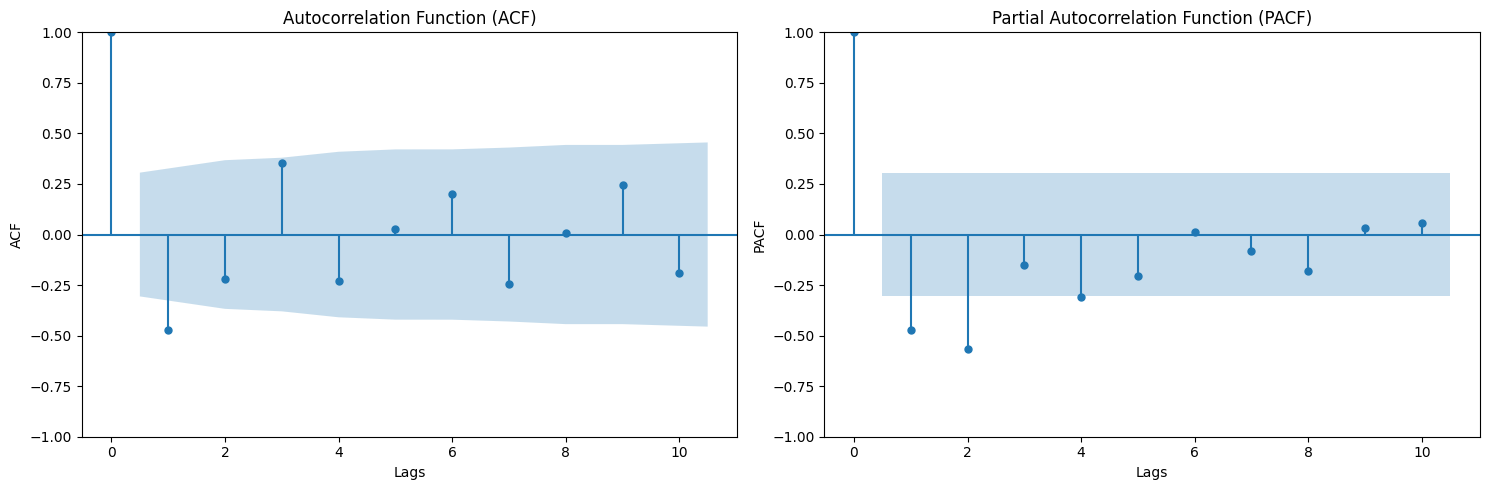

In [15]:
# To help determine which lag and moving average would be beneficial in the ARIMA model, we will use the ACF and PACF.
# The ACF helps measure the correlation between the observations in a time series and their past values. It is important to mention ACF considers all intermediary lags.
# On the other hand, the PACF isolates the correlation at a specific lag, removing the effects of shorter lags, providing a clearer picture of the direct relationship.

ts_data_diff = yearly_forecast_df['TOTAL_QUANTITY'].diff(1).dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(ts_data_diff, lags=10, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')
ax1.set_xlabel('Lags')
ax1.set_ylabel('ACF')

plot_pacf(ts_data_diff, lags=10, method='ywm', ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
ax2.set_xlabel('Lags')
ax2.set_ylabel('PACF')

plt.tight_layout()
plt.show()
# From the plots below, the ACF suggests us to use a model with a moving average of order of 2. 
# The PACF also suggests to use an autoregressive component of 2. 

In [16]:
# Seed for reproducibility
np.random.seed(42)

# ARIMA model
# This training loop finds the best parameters for the model by maximising the AIC. 
arima_model = arima_training_loop(train_df) # EDA suggests 2,1,2.

# ARIMA model 
forecast_steps = 6
arima_forecast = arima_model.forecast(steps=forecast_steps)

# ARIMA performance evaluation
arima_r2, arima_mae, arima_smape = model_metrics(test_list, arima_forecast)

# ARIMA forecast
result_prediction(train_list=train_list, test_list=test_list, forecast_list=arima_forecast, train_months=train_months, test_months=test_months, model_name='Arima')
# Upon initial inspection, the forecast is close to the true values but ARIMA doesn't seem to capture the seasonality information.

Best ARIMA order: (2, 1, 2)
Best AIC: 918.9159747122749
R2: -10.424
Mean Absolute Error: 137946.0
Symmetric Mean Absolute Percentage Error: 8.501


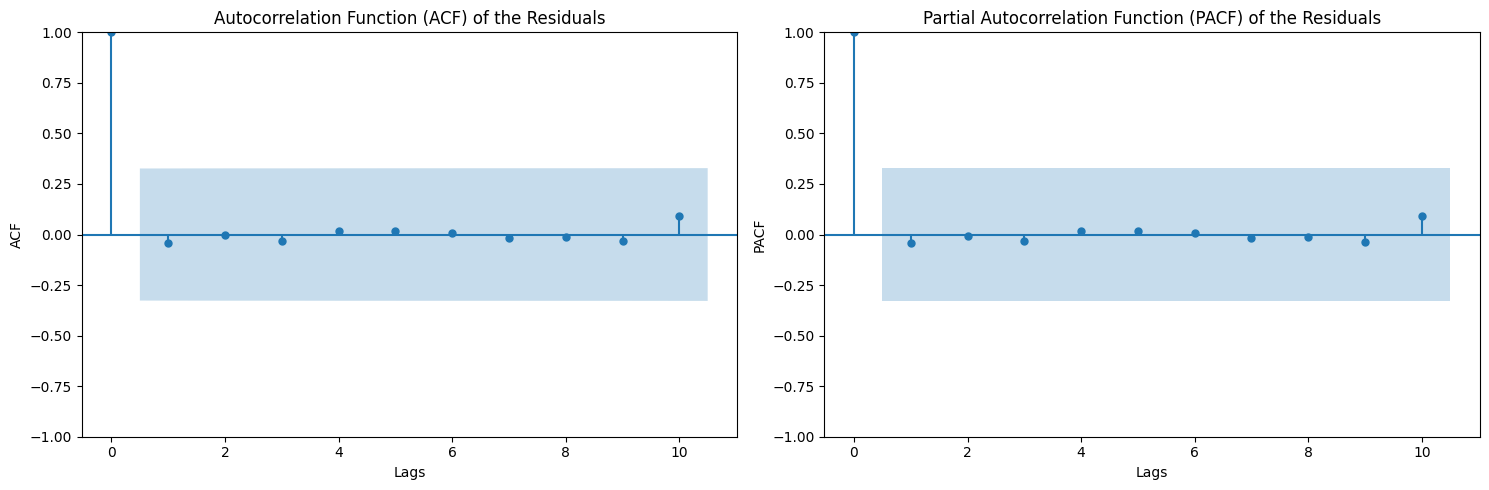

In [17]:
# For model evaluation, we will be focusing on seeing how well the model has captured the data. 
# To do this, we need to ensure the model's residual have no autocorrelation, they have zero mean, be normally distriubted, and have a constant variance. 
# If these conditions are met, the model would have captured the patterns and dependecies, leaving behind only the random white noise. 
arima_residuals = arima_model.resid

# Checking the autocorrelation of the model residuals will help us indicate if we have chosen the correct model hyper-parameters.
# If not, then we will have to adjust out AR and MA terms within our model.

plot_residuals_acf_and_pacf(arima_residuals)
# From the autocorrelation plot we can see the residauls are behaving like white noise.
# Consequently, we need no further changes to the Lag and Moving Average parameters.

In [18]:
# This section will investigate for hetrocedasticity in the residuals and the relationship between the residuals.
plot_residuals(train_months, arima_residuals, title='Plot of ARIMA Residuals')

fitted_values = arima_model.fittedvalues

plot_fitted_vs_residuals(fitted_values, arima_residuals)

# From the residuals vs fitted plots. Residuals indicate the model has fitted well and that there is not hetrocedasticity except for 1 clear outlier on the far left. 
# This corresponds with our first plot which has relatively small residuals in comparison to first forecast.

Shapiro-Wilk Test Statistic: 0.42447503543123144
p-value: 9.774462366017637e-11


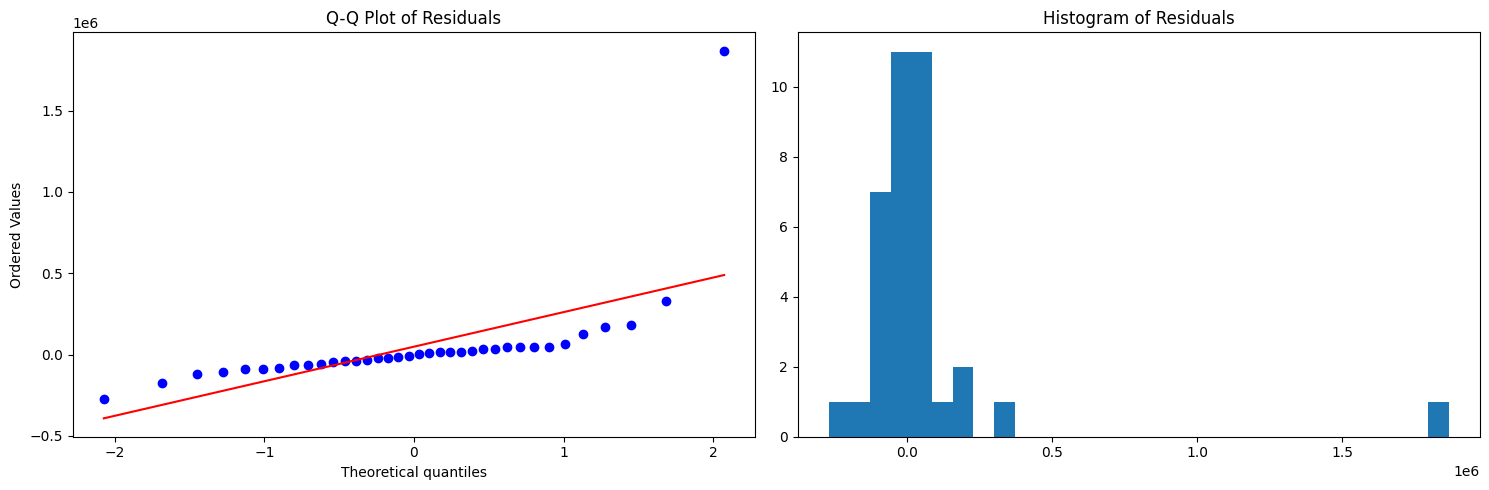

In [19]:
# The goal of this section is check the normality of the residuals. To do this we will plot a QQ-Plot of the residuals and a histogram of the residuals.
# In the QQ-Plot we would expected residuals to fall along the red line and for the histogram the residuals should follow a normal distribution with mean of 0.
# Satisying the normality assumption means the confidence intervals given by the model are accurate and the errors are symmetric around 0. 
# To further test the normality of the model, we will perform a Shapiro-Wilk test.
# H0: The Shaprio-Wilk test for normality has the null hypothesis of the data comes from a normal distribution.
# H1: The alternative hypothese tests to see if the data does not come from a normal distribution.
# To accept the alternative hypothesis we need a p-value less than 0.05.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

stats.probplot(arima_residuals, dist="norm", plot=ax1)
ax1.set_title('Q-Q Plot of Residuals')

ax2.hist(arima_residuals, bins=30)
ax2.set_title('Histogram of Residuals')

fig.tight_layout()
fig.show()

stat, p = shapiro(arima_residuals)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p)
# The arima model results indicate the data does follows a normal distribution, however in both plot there is the clear outlier.
# This outlier is probably the reason behind the model failing the Shaprio-Wilk test of normality with a p value less than 0.05.
# Consequently, from this analysis we can see the model fails to achieve normal residuals and so the confidence intervals of the model cannot be used for accurate forecasts.

## SARIMA

Seasonal AutoRegressive Integrated Moving Average (SARIMA) is an extension of the ARIMA model that incorporates seasonal effects in time series forecasting. Like ARIMA, SARIMA combines autoregressive (AR), integrated (I), and moving average (MA) components, but it adds seasonal counterparts to account for periodic fluctuations in the data. SARIMA is characterized by additional parameters that represent seasonal autoregressive and moving average terms, as well as the seasonal differencing needed to make the series stationary. 

In [20]:
# We'll start by decomposing the graph to spot seasonal trends. This help us determine whether SARIMA is appropriate.
custom_seasonal_decompose(yearly_forecast_df['TOTAL_QUANTITY'].tolist(), months=yearly_forecast_df['YEAR_MONTH'].tolist())
# From these plot we can clearly see there exists a seasonal component of which makes SARIMA applicable and that there is a negative trend.

In [21]:
# To ensure the data is stationary, we will add a differencing of 1 (found in the ARIMA model) along with a seasonal differencing of 12 (for a year). 
season_period = 12 
differencing = 1

data_diff = yearly_forecast_df['TOTAL_QUANTITY'].diff(differencing).dropna()
data_seasonal_diff = data_diff.diff(differencing * season_period).dropna()
offset = len(yearly_forecast_df['TOTAL_QUANTITY'].tolist()) - len(data_seasonal_diff)

# The data should now be stationary. To confirm we will plot it below.
plot_all_regions(yearly_forecast_df['YEAR_MONTH'].iloc[offset:], data_seasonal_diff, title=f'UK Total Quantity Seasonal Differencing')

# For reassurance, we will perform the Adfuller test on the differenced data. 
# We get a p value less than 0.05 indicating the data is stationary.
data = yearly_forecast_df['TOTAL_QUANTITY'].diff(1).dropna().tolist()
print('\nDifferencing of 1:')
adfuller_test(data_seasonal_diff)


Differencing of 1:
ADF Statistic (Differenced): -5.44283325853844
p-value (Differenced): 2.751802948396898e-06


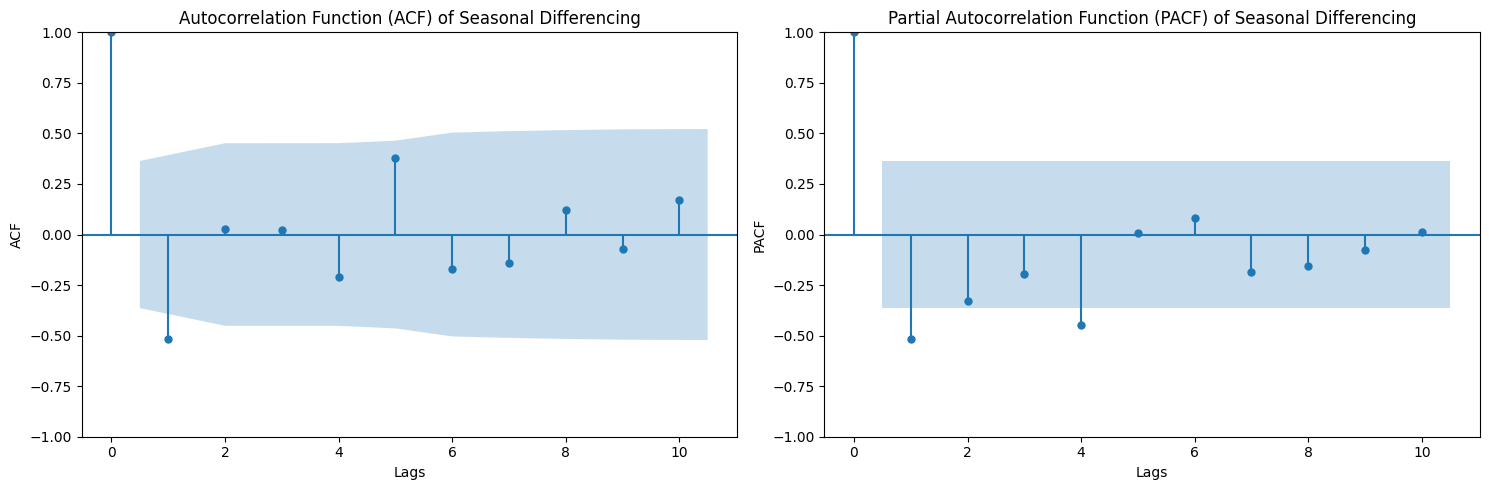

In [22]:
# Before creating the model, we will look at the ACF and the PACF plots (like we did in the ARIMA model).
# These plots tell us the correlation between lagged values which will then indicate to us which hyper-parameters we should use in our model.
# If a lag's correlation exceeds the shaded region, then the lag hyper-parameters in this model should follow this.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(data_seasonal_diff, lags=10, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) of Seasonal Differencing')
ax1.set_xlabel('Lags')
ax1.set_ylabel('ACF')

plot_pacf(data_seasonal_diff, lags=10, method='ywm', ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) of Seasonal Differencing')
ax2.set_xlabel('Lags')
ax2.set_ylabel('PACF')

plt.tight_layout()
plt.show()
# From the plots below, the ACF suggests to use a seasonal moving average term of 1.
# The PCAF term suggests to use a seasonal autoregressive term of 4. In my SARIMA model, I actually decided to change this hyper-parameter to 1 because it would provide a more pessimistic prediction of prescriptions.

In [23]:
# Seed for reproducibility
np.random.seed(42)

# The SARIMA model
sarima_model = SARIMAX(
	train_df['TOTAL_QUANTITY'].tolist(),
	order=(1, 1, 2), 
	seasonal_order=(1, 1, 1, 12) # EDA suggests 4,1,1,12. These hyper-parameters will lead to greater prescription forecasts.
)

# Model fitting
sarima_model_fitted = sarima_model.fit(disp=False)

# Model forecasting 
forecast_steps = 6
sarima_forecast = sarima_model_fitted.forecast(steps=forecast_steps)

# Model evaluation
model_metrics(test_list, sarima_forecast)

# Model results plots
result_prediction(train_list=train_list, test_list=test_list, forecast_list=sarima_forecast, train_months=train_months, test_months=test_months, model_name='Sarima')
# From the plot, we can see SARIMA performs well by retaining the seasonality.

R2: -9.139
Mean Absolute Error: 128614.0
Symmetric Mean Absolute Percentage Error: 7.91


## Evaluating the SARIMA plot.

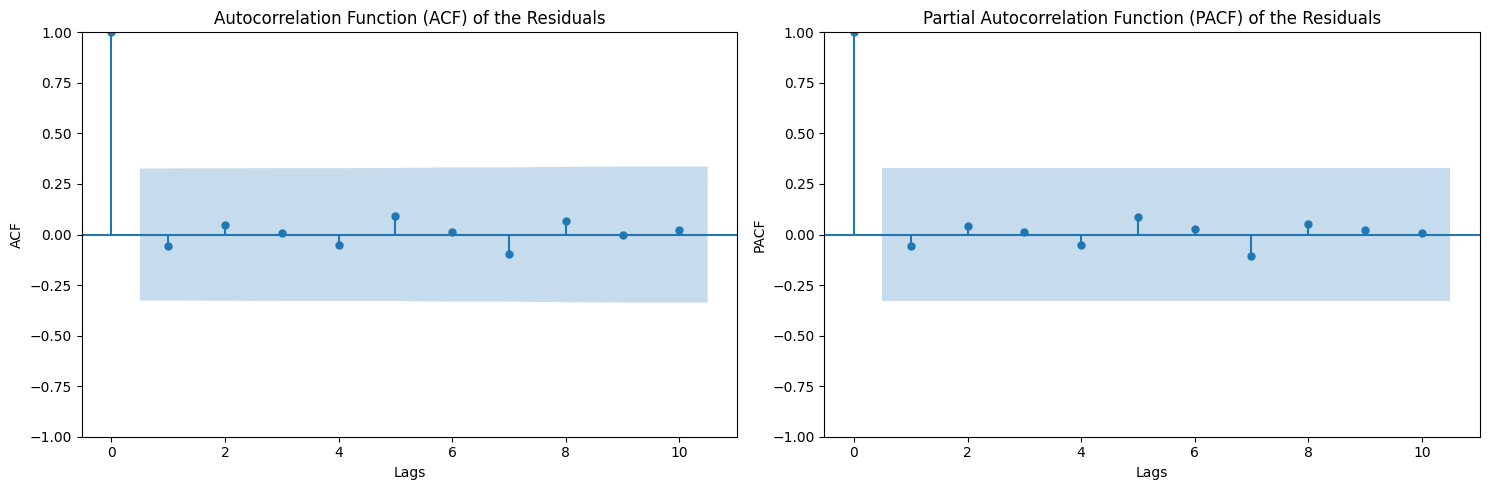

In [24]:
# For model evaluation, we will be focusing on seeing how well the model has captured the data. 
# To do this, we need to ensure the model's residual have no autocorrelation, they have zero mean, be normally distriubted, and have a constant variance. 
# If these conditions are met, the model would have captured the patterns and dependecies, leaving behind only the random white noise. 
sarima_residuals = sarima_model_fitted.resid

# Checking the autocorrelation of the model residuals will help us indicate if we have chosen the correct model hyper-parameters.
# If not, then we will have to adjust out AR and MA terms within our model.

plot_residuals_acf_and_pacf(sarima_residuals)

# From the autocorrelation plot we can see the residauls are behaving like white noise.
# Consequently, we need no further changes to the Lag and Moving Average parameters.

In [25]:
# This section will investigate for hetrocedasticity in the residuals and the relationship between the residuals.
plot_residuals(train_months, sarima_residuals, title='Plot of Residuals')

fitted_values = sarima_model_fitted.fittedvalues

plot_fitted_vs_residuals(fitted_values, sarima_residuals)

# From the residuals vs fitted plots the residuals indicate the model has fitted well and that there is not hetrocedasticity except for 2 clear outliers.
# These two outliers had miscalculated predictions by almost 2 million total presctiptions. This is a major concern, particularly in the second outlier where we predicted almost 2 million less sales. 

Shapiro-Wilk Test Statistic: 0.5521306328831996
p-value: 2.6029719689582016e-09


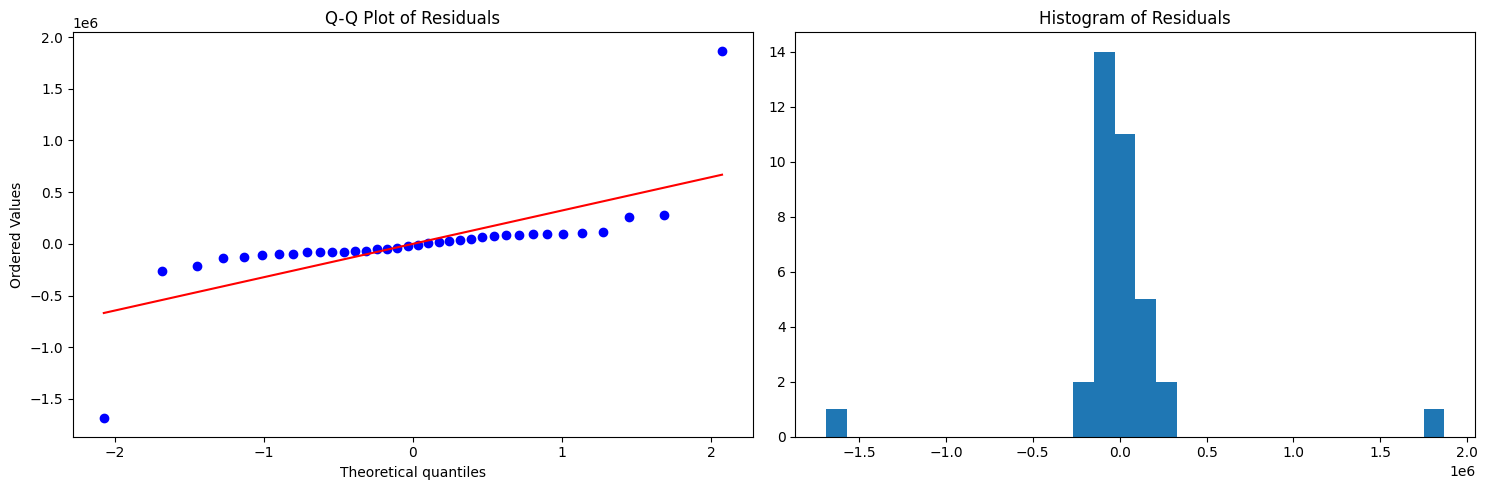

In [26]:
# The goal of this section is check the normality of the residuals. 
# In an ideal situation, the model's residuals will form a normal distribution indicating the model has modelled the data well and will not create unreliable estimates.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

stats.probplot(sarima_residuals, dist="norm", plot=ax1)
ax1.set_title('Q-Q Plot of Residuals')

ax2.hist(sarima_residuals, bins=30)
ax2.set_title('Histogram of Residuals')

fig.tight_layout()
fig.show()

stat, p = shapiro(sarima_residuals)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p)
# From the plots above, we can see the data seems to follow a normal distribution with a few outliers.
# These outliers are clearly the two outliers from the residuals plot and are probably the reason why the Shapiro-Wilk normality test fails. 
# Since the goal of our model is to capture temporal dependencies, and for that, normality of residuals is not critical.
# In this case, the predictive intervals will be impacted, which is not a major concern.

## Prophet
This section will look at a model created by Facebook called Prophet. Prophet is designed to handle time series data with strong seasonal patterns and missing values by decomposing the time series into three main components: trend, seasonality, and holidays, enabling it to capture various patterns effectively. 

12:37:29 - cmdstanpy - INFO - Chain [1] start processing
12:37:29 - cmdstanpy - INFO - Chain [1] done processing


R2: -24.731
Mean Absolute Error: 187045.0
Symmetric Mean Absolute Percentage Error: 11.161


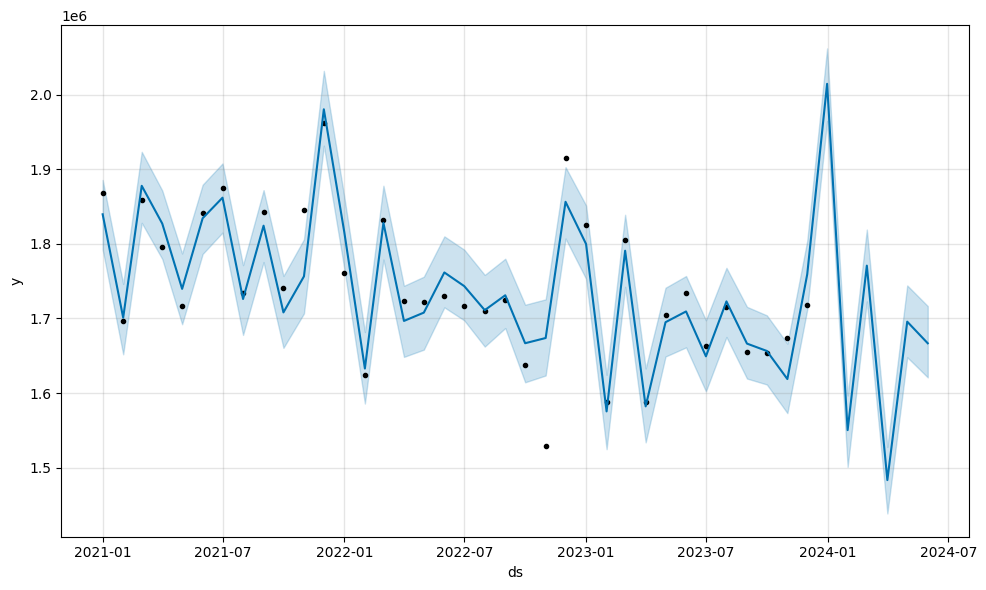

In [27]:
# For this section we will let the Prophet model choose its own parameters which it deems best to model the data.
# Seed for reproducibility
np.random.seed(42)

# Creating a dataframe for prophet.
prophet_df = train_df[['TOTAL_QUANTITY', 'YEAR_MONTH']]
prophet_df.rename(columns={'YEAR_MONTH': 'ds', 'TOTAL_QUANTITY': 'y'}, inplace=True)

# Model fitting
prophet_model = Prophet()

prophet_model.fit(prophet_df)

# Model forecasting
forecast_steps = 6
future = prophet_model.make_future_dataframe(periods=forecast_steps, freq='M')

forecast = prophet_model.predict(future)

prophet_residuals = prophet_df['y'] - forecast['yhat']
prophet_residuals.dropna(inplace=True)

# Model performance analysis
model_metrics(test_list, forecast['yhat'][-forecast_steps:])

prophet_model.plot(forecast)
plt.show()

In [28]:
# Model forecast prediction
result_prediction(train_list=train_list, test_list=test_list, forecast_list=forecast['yhat'][-forecast_steps:], train_months=train_months, test_months=test_months, model_name='Prophet')
# The prophet model forecasts higher prescriptions than were actually given (due to the shortage).
# Prophet also captures the seasonality information well.

In [29]:
# This section will investigate for hetrocedasticity in the residuals and the relationship between the residuals.
plot_residuals(train_months, prophet_residuals, title='Prophet Plot of Residuals')

prophet_fitted_model = prophet_df['y'].tolist()

plot_fitted_vs_residuals(prophet_fitted_model, prophet_residuals)

# From the residuals vs fitted plots we can see that the points are randomly distributed around the red line. This implies the model has captured the variance of the model.
# On the inspection of the residuals plot we can see the residuals are inconsistent and erratic. However, it does not suffer from the massive under or over predictions that the SARIMA model had.

Shapiro-Wilk Test Statistic: 0.8955255801972962
p-value: 0.002580344456193351


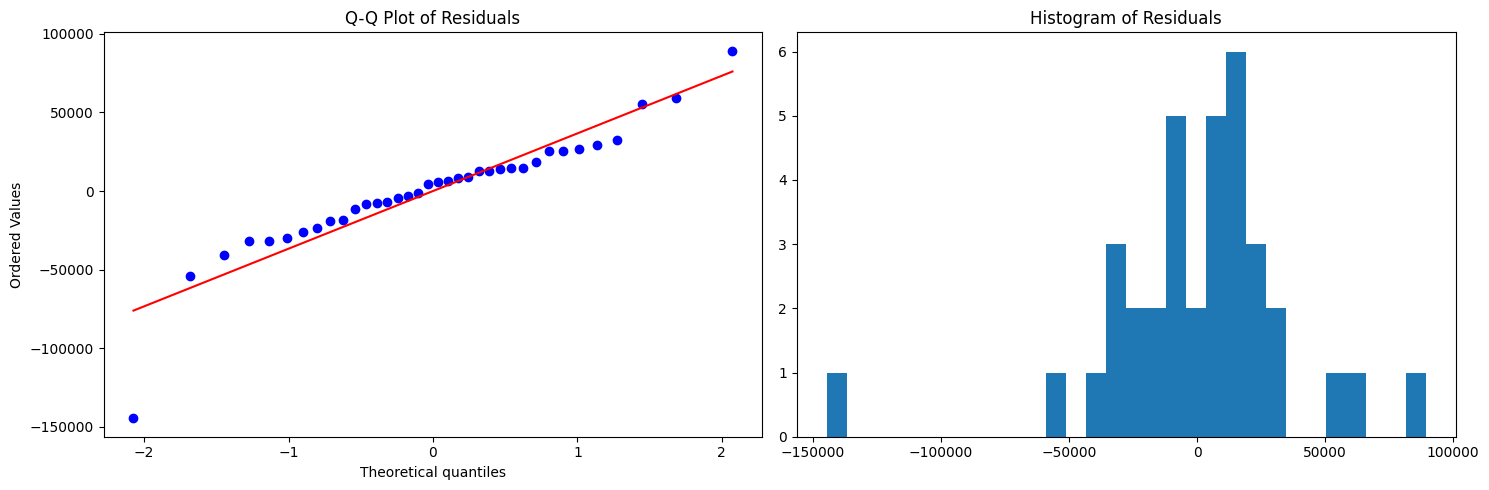

In [30]:
# The goal of this section is check the normality of the residuals. 
# In an ideal situation, the model's residuals will follow a normal distribution.
# Satisying this assumption means the confidence intervals given by the model are accurate and the errors are symmetric around 0. 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

stats.probplot(prophet_residuals, dist="norm", plot=ax1)
ax1.set_title('Q-Q Plot of Residuals')

ax2.hist(prophet_residuals, bins=30)
ax2.set_title('Histogram of Residuals')

fig.tight_layout()
fig.show()

stat, p = shapiro(prophet_residuals)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p)
# From the plots above, we can see the data seems to have a slightly shifted normal distribution with a 1 outlier.
# However, when running the Shapiro-Wilk test for normality, we get a p-value less than 0.05. This indicates that the data is non-normal. 
# Consequenlty, this model will not be good at creating predictive confidence intervals.